In [1]:
# Training data locations
config_fp = '../../data/processed_data.hdf5'
embedding_dir = '../../data/embeddings/'

# Supporting data locations 
mean_dist_fp = '../../data/mean_dists.pt'
mean_sq_dist_fp='../../data/squares.pt'

# Exclude chromosome X from training data so that it can be
# used for network validation 
training_chroms = ['X']# [f'{k}' for k in range(1,23)]

# Training iteration details 
segment_length = 65
batch_size = 64
shuffle_data = True


###########################################################
# Import modules
###########################################################

# This should eventually be performed via relative imports
import sys
sys.path.insert(0,'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/code/diffusion/')
from classifier_free_guidance_greg import GaussianDiffusion, Unet, Trainer
sys.path.insert(1,'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/code/data_utils/')
from DataLoader import DataLoader
from ConfigDataset import ConfigDataset
from EmbeddedRegions import EmbeddedRegions

import pickle # Temporary 
###########################################################
# Build the DataLoader with corresponding datasets. 
###########################################################

print('Preparing Data',flush=True)
print('Loading Configuration Dataset',flush=True)
config_ds = ConfigDataset(
    config_fp,
    segment_length=segment_length,
    batch_size=0,
    normalize_distances=True,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=training_chroms,
    replicates=None,
    shuffle=True,
    allow_overlap=True,
    two_channels=False,
    try_GPU=True,
    mean_dist_fp=mean_dist_fp,
    mean_sq_dist_fp=mean_sq_dist_fp
)

print('Loading Embeddings',flush=True)
er = EmbeddedRegions(
    embedding_dir,
    chroms=training_chroms
)

print('Constructing DataLoader',flush=True)
import copy
dl = DataLoader(
    config_ds,
    copy.deepcopy(er),
    drop_unmatched_pairs=True, 
    shuffle = shuffle_data,
    batch_size=batch_size
)
print('Data Preparation Complete',flush=True)

2024-01-05 09:50:07.188815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Preparing Data
Loading Configuration Dataset
Loading Embeddings
Constructing DataLoader
Data Preparation Complete


In [2]:
er.data.loc[(1300000, 'X', 23600000),'Data']

tensor([[[ 5.3143e+00,  5.7464e+00, -4.5214e-01,  ...,  6.7756e+00,
           2.2600e+00, -3.1154e+00],
         [ 5.3550e+00,  8.8565e+00, -2.1657e-03,  ...,  1.1434e+01,
           2.9626e+00, -2.9614e+00],
         [ 2.6227e+00,  5.3392e+00, -1.3835e-02,  ...,  1.0386e+01,
          -1.9928e+00,  2.0220e+00],
         ...,
         [ 2.1791e+00,  4.7831e+00,  4.3420e-02,  ...,  1.0561e+01,
          -2.0711e+00,  3.0943e+00],
         [ 9.7548e-01,  5.3118e+00, -3.1379e-01,  ...,  1.0800e+01,
          -9.6736e-01,  4.8546e+00],
         [-1.8096e-01,  5.1782e+00,  1.1472e+00,  ...,  7.2766e+00,
          -2.3722e+00,  4.6446e+00]]])

In [3]:
import numpy as np
a = [i[2] for i in dl.embed_idx]
a.sort()
a = np.array(a)
a[(a<23650000)&(a>23500000)]

array([23520000, 23520000, 23520000, 23520000, 23520000, 23520000,
       23520000, 23520000, 23520000, 23520000, 23520000, 23520000,
       23520000, 23520000, 23520000, 23520000, 23520000, 23520000,
       23520000, 23520000, 23520000, 23520000, 23520000, 23520000,
       23520000, 23520000, 23520000, 23520000, 23520000, 23520000,
       23520000, 23520000, 23520000, 23520000, 23520000, 23520000,
       23520000, 23520000, 23520000, 23520000, 23520000, 23520000,
       23520000, 23520000, 23520000, 23520000, 23520000, 23520000,
       23520000, 23520000, 23520000, 23520000, 23520000, 23520000,
       23520000, 23520000, 23520000, 23520000, 23520000, 23520000,
       23520000, 23520000, 23520000, 23520000, 23520000, 23520000,
       23520000, 23520000, 23520000, 23520000, 23520000, 23520000,
       23520000, 23520000, 23520000, 23520000, 23520000, 23520000,
       23520000, 23520000, 23520000, 23520000, 23520000, 23520000,
       23520000, 23520000, 23520000, 23520000, 23520000, 23520

In [4]:
c,image_size,_ = tuple(config_ds.fetch((0,'mat'))[0].shape)
model = Unet(
    dim=64,
    #num_classes,
    cond_drop_prob = 0.5,
    init_dim = None,
    out_dim = None,
    dim_mults=(1, 2, 4, 8),
    channels = c,
    resnet_block_groups = 8,
    learned_variance = False,
    learned_sinusoidal_cond = False,
    random_fourier_features = False,
    learned_sinusoidal_dim = 16,
    attn_dim_head = 32,
    attn_heads = 4,
    embedding_dimensions=tuple(er.ifetch(0)[0].shape)
)

print(image_size,flush=True)

diffusion = GaussianDiffusion(
    model,
    image_size=image_size,
    timesteps = 1000,
    sampling_timesteps = None,
    objective = 'pred_noise',
    beta_schedule = 'cosine',
    ddim_sampling_eta = 1.,
    offset_noise_strength = 0.,
    min_snr_loss_weight = False,
    min_snr_gamma = 5
)

trainer = Trainer(
    diffusion,
    dl,
    train_batch_size = 128,
    gradient_accumulate_every = 1,
    augment_horizontal_flip = True,
    train_lr = 1e-4,
    train_num_steps = 600000,
    ema_update_every = 10,
    ema_decay = 0.995,
    adam_betas = (0.9, 0.99),
    save_and_sample_every = 5000,
    num_samples = 25,
    results_folder = '../../data/models/diffusion_small',#'./results_small',
    amp = False, # using false here turns off mixed precision 
    mixed_precision_type = 'fp16',
    split_batches = True,
    convert_image_to = None,
    calculate_fid = False, #True,
    inception_block_idx = 2048,
    max_grad_norm = 1.,
    num_fid_samples = 50000,
    save_best_and_latest_only = False
)

64


In [5]:
import torch
import numpy as np

class DataProcessor: 
    def __init__(
        self,
        mean_dist_fp='../../data/mean_dists.pt',
        mean_sq_dist_fp='../../data/squares.pt',
        dtype=torch.double,
        seg_len = None, # Number of beads
        device = None,
        preserve_asymmetries=True,
        data = None,
        data_is_flat = None,
        preserve_data_dtype = True
    ): 

        # Assume GPU is desired unless specified otherwise
        if device is None: 
            try:
                device = torch.empty(1).cuda().device
            except:
                device = torch.empty(1).device

        mean_dist = torch.load(mean_dist_fp,map_location=device).flatten().to(dtype)
        mean_square_dist = torch.load(mean_sq_dist_fp,map_location=device).flatten().to(dtype)
        if seg_len is not None: 
            mean_dist = mean_dist[:seg_len]
            mean_square_dist = mean_square_dist[:seg_len]
        
        self.dist_std = (mean_square_dist - mean_dist**2).sqrt()
        self.inv_beta = torch.sqrt( 2*mean_square_dist/3 )
        self.inv_beta_sigmoid = torch.sigmoid( -self.inv_beta/self.dist_std )
        self.complement_inv_beta_sigmoid = 1 - self.inv_beta_sigmoid

        self.preserve_asymmetries = preserve_asymmetries
        if data is not None: 
            self.set_data(data,data_is_flat,preserve_data_dtype)
        else: 
            self.data = data

    @property
    def dtype(self):
        return self.dist_std.dtype

    @property
    def device(self):
        return self.dist_std.device

    @property
    def seg_len(self): 
        return len(self.dist_std)

    def __len__(self): 
        if self.batch is None: 
            return 0
        elif len(self.data.shape) == 1:
            return 1
        elif (len(self.data.shape) == 2) and (not self.is_flat):
            return 1
        else:
            return self.data.shape[0]
        
    def to(self,*args):
        for attr in dir(self): 
            if type(getattr(self, attr)) == torch.Tensor:
                for arg in args:
                    setattr(self, attr, getattr(self, attr).clone().to(arg))

    #####
    # Processing data
    def _infer_seg_len_(self): 
        # sample_len is an integer with length N(N-1)//2 
        if self.is_flat is None: 
            # Must infer matrix vs flattened form 
            if (len(self.batch.shape) == 1) or (self.batch.shape[-1] != self.batch.shape[-2]):
                self.is_flat = True
            else: 
                # Assumes batch.shape[-1] == batch.shape[-2] only occurs if in matrix form, 
                # which is overwhelmingly likely. 
                self.is_flat = False 
        
        if self.is_flat:
            M = self.batch.shape[0] 
            NN = (1+np.sqrt(1+8*M))/2 # Quadratic formula
            N = int(NN)
            assert N == NN, f'Invalid batch size. Cannot infer number of beads in the segment!'
        else: 
            assert len(self.batch.shape) > 1, \
            'User indicated that the provided batch was not flattened, but one-dimensional data was provided!'
            N = self.batch.shape[-1]

        # Finally, compute the number of beads in the segment. 
        self.batch_seg_len = N 
        self.triu_indices = torch.triu_indices(N,N,0)
        self.sep = self.triu_indices[1] - self.triu_indices[0] 

    def flatten(self): 
        
        if self.is_flat:
            return self.batch.clone()

        i,j = self.triu_indices
        return self.batch[...,i,j].clone()
        
    
    def flatten_(self,force=False):

        if self.is_flat:
            return 

        b = self.batch
        if not force and self.preserve_asymmetries and (b != b.transpose(-2,-1)).any():
            return # Flattening would cause us to lose the asymmetry in the matrix

        i,j = self.triu_indices

        self.batch = b[...,i,j]
        self.is_flat = True

    def unflatten(self):

        if not self.is_flat:
            return self.batch.clone() # Already in matrix form

        batch = torch.empty(*self.batch.shape[:-1],self.batch_seg_len,self.batch_seg_len,dtype=self.dtype,device=self.device)
        i,j = self.triu_indices

        batch[...,i,j] = self.batch 
        batch[...,j,i] = self.batch 
        
        return batch 
    
    def unflatten_(self):

        self.batch = self.unflatten()
        self.is_flat = False 
    
    
    def set_data(self,batch,is_flat=None,return_original_dtype=True):
        # is_flat == True: Last dimension contains the upper triangle of the distance matrix. 
        # is_flat == False: Data is still in matrix form, in the final 2 dimensions. 
        # is_flat is None: Must infer whether data is in the matrix or flattened form.

        # Convert numpy objects to torch tensors
        if type(batch) == np.ndarray: 
            batch = torch.from_numpy(batch) 

        # Validate input. 
        assert type(batch) == torch.Tensor, \
        f'The batch argument must be a torch.Tensor. Received {type(batch)}'
        
        assert type(is_flat)==bool or is_flat is None, \
        f'The is_flat argument must be one of True, False, or None. Received {type(is_flat)}'
        
        assert type(return_original_dtype) == bool, \
        f'The return_original_dtype argument must be either True or False. Received {type(return_original_dtype)}.'

        # Save the data to this DataProcessor object
        self.batch_dtype = batch.dtype if return_original_dtype else self.dtype
        self.batch = batch.clone().to(self.device,self.dtype)
        self.is_flat = is_flat
        self._infer_seg_len_() # Determines the number of genomic loci in the map
        self.flatten_() # Reduces memory usage & computational requirements. 

        # Infer whether this is in the normalized or distance form 
        self.normalized = (self.batch <= 1).all()

    ''' # Must still add this functionality 
    def normalize_dists(self,dists):
        if not self.norm_dists:
            return dists
        sep = self.sep_idx
        i,j = self.triu_indices
        bs = dists.shape[0] #self.batch_size
        j = j-1
        dists-= self.inv_beta[sep].repeat(bs,1) # Should eventually replace with expand to save memory 
        dists/= self.dist_std[sep].repeat(bs,1)
        dists.sigmoid_()
        dists-= self.inv_beta_sigmoid[sep].repeat(bs,1)
        dists/= self.complement_inv_beta_sigmoid[sep].repeat(bs,1)
        return dists 
    '''

    def _unnormalize_(self): 
        # Dists must be provided in flattened form
        sep,dists = self.sep, self.batch.clone()
        
        dists*= self.complement_inv_beta_sigmoid[sep].expand(*dists.shape[:-1],-1)
        dists+= self.inv_beta_sigmoid[sep].expand(*dists.shape[:-1],-1)
        dists.logit_()
        dists*= self.dist_std[sep].expand(*dists.shape[:-1],-1)
        dists+= self.inv_beta[sep].expand(*dists.shape[:-1],-1)
        
        '''
        dists*= self.complement_inv_beta_sigmoid[sep].repeat(*dists.shape[:-1],1)
        dists+= self.inv_beta_sigmoid[sep].repeat(*dists.shape[:-1],1)
        dists.logit_()
        dists*= self.dist_std[sep].repeat(*dists.shape[:-1],1)
        dists+= self.inv_beta[sep].repeat(*dists.shape[:-1],1)
        '''
        self.normalized = False
        self.batch = dists
    
    def unnormalize_(self):#,batch=None,is_flat=None,return_original_dtype=True):

        #if batch is not None:
        #    self.set_data(batch,is_flat,return_original_dtype)

        assert self.batch_seg_len <= self.seg_len, \
        f'mean/variance data insufficient for data with {self.batch_self_len} genomic bins.'
        
        if self.normalized: # Only perform these operations if the data is normalized
            if self.is_flat: 
                self._unnormalize_(self.batch)
            else:
                # We must contend with the asymmetric data
                batch = torch.empty_like(self.batch)
                
                i,j = torch.triu_indices(self.batch_seg_len,self.batch_seg_len,0)
                b = self.batch
                for ii,jj in [(i,j),(j,i)]: 
                        
                    self.batch = b[...,ii,jj]
                    self._unnormalize_()
                    batch[...,ii,jj] = self.batch 
                self.batch = batch 

            self.normalized = False 
            
        return self.unflatten()

    def get_scHiC(self,threshold=2):

        # Convert data to distances, unflatten, and compare to the threshold
        return (self.unnormalize_() < threshold).to(self.batch_dtype)
        
        

In [6]:
import os
save_folder='../../data/models/diffusion_small'#'./results_large'
if os.path.exists(save_folder): 
    milestone = 0 
    for k in os.listdir(save_folder):
        try: 
            n = int( k.split('-')[-1].split('.')[0] )
            if n > milestone: 
                milestone = n
        except:
            pass
    assert milestone > 0 # During testing
    trainer.load(milestone=milestone)

In [12]:
milestone

85

In [9]:
import pandas as pd
embeddings = pd.read_pickle('../../data/embeddings/chrom_X.tar.gz')

In [68]:
def fetch_embedding(embeddings,chrom,start,stop=None,length=None,device=None): 
    '''
    If both stop & length are passed, length is ignored 
    '''
    
    if stop is None: 
        assert length is not None, "Must specify either ending genomic index or length of the region"
        stop = start + length 
    
    if start > stop: 
        start, stop = stop, start
        
    length = stop - start 
    
    emb = embeddings.loc[(length,chrom,start)]
    return torch.stack(list(emb.values),dim=0).to(device)

In [84]:
import torch

#emb = torch.stack(embeddings.iloc[:10,:].values.flatten().tolist(),dim=0).to(diffusion.device)
#trainer.model.eval()
#sample = trainer.model.sample(emb[:1,...].expand(10,-1,-1,-1))

chrom = 'X'
start = 220_000
length = 1_300_000
n_configs = 100

trainer.model.eval()
emb = fetch_embedding(embeddings,chrom,start,length=length,device=trainer.device)
sample = trainer.model.sample(emb.expand(n_configs,-1,-1,-1),cond_scale = 1., rescaled_phi = 0.5)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

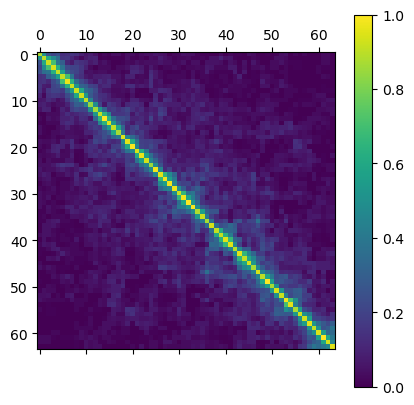

In [85]:
import matplotlib.pyplot as plt
sample1 = DataProcessor(data=sample)
scHiC_maps = sample1.get_scHiC()
hic_map = scHiC_maps.mean(0)[0,...].cpu().numpy()
plt.matshow(hic_map)
plt.colorbar()

### With better plotting, new contact calculations 

#### Plot generated sample

In [86]:
# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cooltools.lib.plotting # provides 'fall' colormap

In [87]:
norm = LogNorm(vmax=1) 
def plot_hic(hic_map,norm=norm):
    
    fig = plt.figure()
    ax = fig.add_subplot(111) 
    
    im = ax.matshow(
        hic_map.cpu().numpy(),
        norm=norm,
        cmap='fall',
        #extent=(region[1], region[2], region[2], region[1])
    );
    ax.xaxis.set_visible(False)
    
    cbar = fig.colorbar(im, label='Interaction Frequencies',location='right');

    return fig,ax,im,cbar

In [88]:
from Sample import Sample
sample2 = Sample(data = sample)

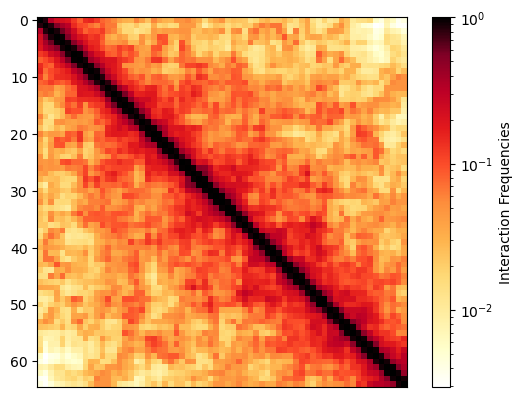

In [97]:
prob_map = sample2.contact_probabilities(r_c=1.76,sigma=8)
plot_hic(prob_map);

In [90]:
def get_region(embeddings,index): 
    # rl: Region Length
    # ch: Chromosome
    # gi: Genomic Index (start of the region) 
    rl, ch, gi = embeddings.index[index]
    return ch, gi, rl

#### Plot experimental Hi-C map 

In [98]:
clr = cooler.Cooler('../../data/outside/GM12878_hg19.mcool::/resolutions/20000')

In [76]:
chrom, start, length = get_region(embeddings,0)




In [99]:
import numpy as np
a = np.zeros(10)
type(a)

numpy.ndarray

In [100]:
type(a) == np.ndarray

True

In [5]:
import numpy as np
len(np.unique(config_ds.start_indices))

5726387

In [13]:
dl.index.sort_index()

,coord_idx,Chromosome,Genomic_Index,embed_idx
0,"(0, mat)",1,1420000,"(1300000, 1, 1420000)"
0,"(0, pat)",1,1420000,"(1300000, 1, 1420000)"
1,"(117823, mat)",1,1420000,"(1300000, 1, 1420000)"
1,"(117823, pat)",1,1420000,"(1300000, 1, 1420000)"
2,"(235660, pat)",1,1420000,"(1300000, 1, 1420000)"
...,...,...,...,...
5705642,"(5771412, pat)",18,18380000,"(1300000, 18, 18380000)"
5705643,"(5902103, pat)",18,18380000,"(1300000, 18, 18380000)"
5705643,"(5902103, mat)",18,18380000,"(1300000, 18, 18380000)"
5705644,"(6032851, mat)",18,18380000,"(1300000, 18, 18380000)"


In [14]:
a = next(dl) :

In [16]:
a[0].shape

torch.Size([64, 1, 64, 64])

In [17]:
a[1].shape

torch.Size([64, 1, 260, 256])

In [2]:
# Basic attributes
configs = config_ds
embedded_regions = er
shuffle = True#shuffle
batch_size = 64#batch_size 
epoch = 0 
internal_idx = 0 

In [3]:
con, er = configs, embedded_regions

In [8]:
import pandas as pd
import numpy as np
import torch 

In [9]:
df = pd.DataFrame()
df['coord_idx'] = con.start_indices # Starting position, first index position of con.coords
df['Chromosome'] = ''
df['Genomic_Index'] = con.genomic_index[con.start_indices] # Starting position, genomic index of chromosome

In [10]:
s = df['coord_idx'] 
todo = np.ones(len(df),dtype=bool) # Saves some time with comparisons in the loop
for _,row in con.coord_info.iterrows():
    idx = todo & (s <= row['idx_max']) & (s >= row['idx_min'])
    df.loc[idx,'Chromosome'] = row['Chromosome'] 
    todo&= ~idx

In [14]:
len(s) 

5726387

In [16]:
con.coord_info.iloc[-1,:]

Accession     GSE117876
Organism          Human
Cell_Type       GM12878
Cell                 17
Replicate             2
Chromosome           22
idx_min         6043075
idx_max         6044756
Name: 1034, dtype: object

In [19]:
for i in range(1,len(con.coord_info)): 
    assert con.coord_info['idx_min'].values[i] == con.coord_info['idx_max'].values[i-1]+1

In [31]:
con.coords.shape

torch.Size([6044757, 6])

In [34]:
len(np.unique(con.start_indices))

6857

In [35]:
'''
Todo: For some reason, the fetch function returns an object size 2xNxN when two_channels=False and only
one configuration is requested. 
'''

import numpy as np
import torch
import pandas as pd
import random 

def reduce_coord_info(coord_info,geos,organisms,cell_types,cell_numbers,chroms,replicates):
    '''
    Reduce the coord_info object to the rows that satisfy all desired restrictions. 
    '''

    key_vals = {
        'Accession':geos,
        'Organism':organisms,
        'Cell_Type':cell_types,
        'Cell':cell_numbers,
        'Replicate':replicates,
        'Chromosome':chroms
    }

    for col, restrictions in key_vals.items():
        assert len(coord_info) > 0, "No data satisfies your desired restrictions."
        if restrictions is None:
            continue
        idx = np.zeros(len(coord_info),dtype=bool)
        vals = coord_info[col].values
        for r in restrictions: 
            idx|= vals == r
        idx = np.where(idx)[0]
        coord_info = coord_info.iloc[idx]

    # Reset the index in the coord_info DataFrame to make indexing it later more straightforward. 
    coord_info.reset_index(drop=True,inplace=True)
    
    return coord_info 

def load_coords(filepath,coord_info):

    index_ranges = [[coord_info['idx_min'].iloc[0],coord_info['idx_max'].iloc[0]+1]]
    for k,row in coord_info.iterrows(): 
        if k == 0:
            continue
        if index_ranges[-1][1] == row['idx_min']:
            index_ranges[-1][1] = row['idx_max']+1
        else: 
            index_ranges.append([row['idx_min'],row['idx_max']+1])

    data = []
    for range in index_ranges: 
        data.append(
            pd.read_hdf(
                filepath,
                key='Coordinates',
                start=range[0],
                stop=range[1]
            )
        )

    data = pd.concat(
        data,
        axis=0,
        ignore_index=True
    )
    data.reset_index(drop=True,inplace=True)
    
    return data

def get_valid_starts(permitted_lengths,segment_length,allow_overlap=False): 
        '''
        Find all indices where, including that bead, there are segment_length
        sequential beads in a row (i.e. not removed during Dip-C clean process)

        If allow_overlap is set to False, the indices returned will represent
        the starting points for non-overlapping regions only
        '''

        pl = permitted_lengths 
    
        # If overlapping regions are fine, simply need segments long enough
        # to satisfy the following 
        if allow_overlap:
            return pl[pl > segment_length-2]

        # A monomer at the extreme end of one segment can appear as the start of the next 
        # segment per this setup 
        perlens_for_no_overlap = np.arange(segment_length-1,pl.max()+.5,segment_length-1)
        perlens_for_no_overlap = perlens_for_no_overlap.reshape(1,len(perlens_for_no_overlap))

        pl = pl.reshape(len(pl),1)
        return np.where( (pl == perlens_for_no_overlap).any(1) )[0]

def reset_coord_info_indices(coord_info):
    
    # Make the indices match the DataFrame containing actual coordinates 
    coord_info.loc[0,'idx_max'] = coord_info.loc[0,'idx_max'] - coord_info.loc[0,'idx_min']
    coord_info.loc[0,'idx_min'] = 0 
    for i in range(1,len(coord_info)):
        length = coord_info.loc[i,'idx_max'] - coord_info.loc[i,'idx_min']
        coord_info.loc[i,'idx_min'] = coord_info.loc[i-1,'idx_max'] + 1
        coord_info.loc[i,'idx_max'] = coord_info.loc[i,'idx_min'] + length

    return coord_info

class ConfigDataset:

    def __init__(
        self,
        filepath,
        segment_length=64,
        batch_size=64,
        normalize_distances=True,
        geos=None,
        organisms=None,
        cell_types=None,
        cell_numbers=None,
        chroms=None,
        replicates=None,
        shuffle=True,
        allow_overlap=False,
        two_channels=False,
        try_GPU=True,
        mean_dist_fp='../../data/mean_dists.pt',
        mean_sq_dist_fp='../../data/squares.pt'
    ):
        '''
        filepath: Dataset location. Should be formatted as designed for this study
        segment_length: The number of monomers relevant to the distance maps 
        batch_size: Number of configurations per batch 
        shuffle: Should the sample indices be shuffled before each epoch? 
        allow_overlap: Can the dataset include overlapping regions (True), 
                       or should they all be fully independent (False)? 
        two_channels: Does the data include the maternal & paternal structures
                        in the same sample (two channels of the image)? Otherwise, 
                        returns one or the other. 

        To choose a subset of the overall dataset, use the following variables. In all cases, 
        a value of None means no restriction on this parameter. Otherwise, a list of those 
        parameters to be INCLUDED should be provided. 
            1. geos: GEO accession numbers
            2. organisms: Organism, e.g. 'Human' or 'Mouse'
            3. cell_types: Cell type 
            4. cell_numbers: Cell number within a dataset specified above. Should be np.int64
            5. chroms: Chromosomes. Should be passed as a string. 
            6. replicates: Replicates from Dip-C procedure on the same cell's data
        '''

        # Assign qualities where relevant 
        filepath = filepath 
        seg_len = segment_length 
        batch_size = batch_size
        shuffle = shuffle
        allow_overlap = allow_overlap
        two_channels = two_channels
        norm_dists = normalize_distances

        # torch.cuda.is_available() doesn't work properly on 
        # SuperCloud, so use this approach instead. 
        try: 
            assert try_GPU
            device = torch.empty(1).cuda().device
        except:
            device = torch.empty(1).device

        # Load the information object to help us decide which portion of the dataset to load from storage
        coord_info = pd.read_hdf(
            filepath,
            key='coord_info'
        )

        # Find the indices to load from memory
        coord_info = reduce_coord_info(coord_info,geos,organisms,cell_types,cell_numbers,chroms,replicates)

        # Fetch the desired rows from memory
        coord_df = load_coords(filepath,coord_info)

        # Place information from the coord_df object into objects which improve speed downstream 
        coords = torch.from_numpy(coord_df[['mat_x','mat_y','mat_z','pat_x','pat_y','pat_z']].values).to(torch.double)
        genomic_index = coord_df['Genomic_Index'].values

        # Get the indices of valid starting positions to obtain uninterrupted regions of the referenced dimensions
        start_indices = get_valid_starts(coord_df['Permitted_Lengths'].values,segment_length,allow_overlap)

        # Set the indices of the coord_info object to match the loaded dataset
        coord_info = reset_coord_info_indices(coord_info)

        # Track the sample indices. This can be shuffled without perturbing the main dataset 
        #data_index = 
        if two_channels: 
            data_index = start_indices
        else: 
            n = len(start_indices)
            data_index = np.empty((2*n,2),dtype=np.int64)
            data_index[:n,0] = start_indices # Rows in coords object
            data_index[:n,1] = 0 # Maternal is in columns 0,1,2
            data_index[n:,0] = start_indices 
            data_index[n:,1] = 3 # Paternal is in columns 3,4,5

        # Define some internal indexing objects to keep track of the dataset
        epoch = 0     # Which epoch are we on? 
        inner_idx = 0 # Keep track of which row in the dataset we're considering
        reset_index() # This will shuffle the index (if desired) and increase epoch to 1
        triu_indices = torch.triu_indices(segment_length,segment_length,1) 

        # The following is used to index the distance objects, which are indexed such that
        # sep[i] corresponds to i+1, so subtract the 1
        sep_idx = triu_indices[1] - triu_indices[0] - 1  
        

        # Initialize some objects used during batch fetching/manipulation
        batch_coords = torch.empty(batch_size,seg_len,3*(1+int(two_channels)),
                                        device=device,dtype=coords.dtype)
        batch_dists = torch.empty(batch_size,1+int(two_channels),seg_len-1,seg_len-1,
                                      device=device,dtype=torch.float)

        # Load the distance vs genomic separation relationships used to normalize the distance data
        # for use in the signmoid mod. Afterwards, process the values we use at each iteration
        dt = batch_coords.dtype
        mean_dist = torch.load(mean_dist_fp,map_location=device).flatten()[:seg_len].to(dt)
        mean_square_dist = torch.load(mean_sq_dist_fp,map_location=device).flatten()[:seg_len].to(dt)
        dist_std = (mean_square_dist - mean_dist**2).sqrt()
        inv_beta = torch.sqrt( 2*mean_square_dist/3 )
        inv_beta_sigmoid = torch.sigmoid( -inv_beta/dist_std )
        complement_inv_beta_sigmoid = 1 - inv_beta_sigmoid

    def reset_index(self):

        if shuffle: 
            n_unused = len(self) - inner_idx
            if n_unused > 0 and n_unused < batch_size: 
                # Place the unused data at the front, if the epoch
                # hasn't *totally* completed but is less than a 
                # batch length away. 
                temp = data_index[-n_unused:,...].copy()
                idx = np.arange(len(self)-n_unused)
                data_index[n_unused:,...] = data_index[idx,...]
                data_index[:n_unused,...] = temp 
            else:
                idx = np.arange(data_index.shape[0])
                random.shuffle(idx)
                data_index = data_index[idx,...]

        epoch+=1
        inner_idx = 0

    def normalize_dists(self,dists):
        if not norm_dists:
            return dists
        sep = sep_idx
        i,j = triu_indices
        bs = dists.shape[0] #batch_size
        j = j-1
        dists-= inv_beta[sep].repeat(bs,1) # Should eventually replace with expand to save memory 
        dists/= dist_std[sep].repeat(bs,1)
        dists.sigmoid_()
        dists-= inv_beta_sigmoid[sep].repeat(bs,1)
        dists/= complement_inv_beta_sigmoid[sep].repeat(bs,1)
        return dists 

    def get_genomic_regions(self):
    
        coord_info = coord_info
        start_indices = start_indices
        gen_idx = genomic_index
        nbeads = seg_len
    
        regions = pd.DataFrame({
            'Start':gen_idx[start_indices]
        })
        regions['Stop'] = regions['Start'] + (gen_idx[start_indices[0]+1]- gen_idx[start_indices[0]]) * seg_len
        regions.insert(0,'Chromosome','')
    
        for _,row in coord_info.iterrows():
            idx = (start_indices >= row['idx_min']) & (start_indices <= row['idx_max'])
            if idx.any(): 
                regions.loc[idx,'Chromosome'] = row['Chromosome']
    
        regions.drop_duplicates(ignore_index=True,inplace=True)
        
        return regions

    def fetch_coords(self,start_idx): 
        
        if type(start_idx) == tuple: 
            #assert start[1] in ['mat','pat']
            y = start_idx[0]
            x_idxs = [3*(start_idx[1] == 'pat')]
        else:
            y = start_idx
            x_idxs = [0,3] 

        coords = []
        for x_idx in x_idxs: 
            coords.append(coords[y:y+seg_len,x_idx:x_idx+3])

        return torch.stack(coords,dim=0)
            

    def fetch(self,start_indices):

        # Get the relevant coordinates
        if type(start_indices) == int or type(start_indices) == tuple: 
            start_indices = [start_indices]

        coords = torch.stack([fetch_coords(i) for i in start_indices],dim=0).to(device)

        # Compute distances; ignore duplicates
        i,j = triu_indices
        dists = torch.cdist(coords,coords)[...,i,j]

        # Normalize distances (if desired) 
        if norm_dists: 
            s = dists.shape
            dists = normalize_dists(dists.flatten(0,-2)).to(batch_dists.dtype).reshape(s)

        b,c,h = dists.shape[0],dists.shape[1],seg_len-1
        batch = torch.empty((b,c,h,h),dtype=torch.float,device=device)
        j = j-1
        batch[:,:,i,j] = dists.to(torch.float)
        batch[:,:,j,i] = dists.to(torch.float)
        
        return batch 
    
    def __len__(self):
        return data_index.shape[0]
    
    def __next__(self):

        # Avoid out of range issues
        if inner_idx + batch_size >= len(self):
            reset_index()

        # Get the section of the main dataset we're pulling from 
        idx = data_index[inner_idx:inner_idx+batch_size,...]
        
        # Get the distance map associated with the inquired regions
        if two_channels:
            batch_coords[:] = coords[idx,:].to(device).reshape_as(batch_coords)
        else:
            for i in range(batch_size):
                i0 = idx[i,0]
                i1 = idx[i,1]
                batch_coords[i,:,:] = coords[i0:i0+seg_len,i1:i1+3]
                #batch_coords[sub_idx,i,:] = coords[idx[sub_idx,0],:3].to(device).reshape_as(batch_coords[sub_idx,:,:])
                #sub_idx^= True # Flips to paternal index
                #batch_coords[sub_idx,i,:] = coords[idx[sub_idx,0],3:].to(device).reshape_as(batch_coords[sub_idx,:,:])

        i,j = triu_indices
        for k in range(batch_dists.shape[1]):
            ii = 3*k
            jj = ii+3
            dists = torch.cdist(batch_coords[:,:,ii:jj],batch_coords[:,:,ii:jj])[:,i,j]
            batch_dists[:,k,i,j-1] = normalize_dists(dists).to(batch_dists.dtype) 
        batch_dists[:,:,j-1,i] = batch_dists[:,:,i,j-1]

        inner_idx+= batch_size 

        return batch_dists 
            
        


In [54]:
filepath = '../../data/processed_data.hdf5'
segment_length=64
batch_size=64
normalize_distances=True
geos=None
organisms=None
cell_types=None
cell_numbers=None
chroms=[f'{k}' for k in range(1,23)]#None
replicates=None
shuffle=True
allow_overlap=True#False
two_channels=False
try_GPU=True
mean_dist_fp='../../data/mean_dists.pt'
mean_sq_dist_fp='../../data/squares.pt'

# Assign qualities where relevant 
filepath = filepath 
seg_len = segment_length 
batch_size = batch_size
shuffle = shuffle
allow_overlap = allow_overlap
two_channels = two_channels
norm_dists = normalize_distances

# torch.cuda.is_available() doesn't work properly on 
# SuperCloud, so use this approach instead. 
try: 
    assert try_GPU
    device = torch.empty(1).cuda().device
except:
    device = torch.empty(1).device

coord_info = pd.read_hdf(
    filepath,
    key='coord_info'
)

# Find the indices to load from memory
coord_info = reduce_coord_info(coord_info,geos,organisms,cell_types,cell_numbers,chroms,replicates)

# Fetch the desired rows from memory
coord_df = load_coords(filepath,coord_info)

# Place information from the coord_df object into objects which improve speed downstream 
coords = torch.from_numpy(coord_df[['mat_x','mat_y','mat_z','pat_x','pat_y','pat_z']].values).to(torch.double)
genomic_index = coord_df['Genomic_Index'].values

# Get the indices of valid starting positions to obtain uninterrupted regions of the referenced dimensions
start_indices = get_valid_starts(coord_df['Permitted_Lengths'].values,segment_length,allow_overlap)

# Set the indices of the coord_info object to match the loaded dataset
coord_info = reset_coord_info_indices(coord_info)

# Track the sample indices. This can be shuffled without perturbing the main dataset 
#data_index = 
if two_channels: 
    data_index = start_indices
else: 
    n = len(start_indices)
    data_index = np.empty((2*n,2),dtype=np.int64)
    data_index[:n,0] = start_indices # Rows in coords object
    data_index[:n,1] = 0 # Maternal is in columns 0,1,2
    data_index[n:,0] = start_indices 
    data_index[n:,1] = 3 # Paternal is in columns 3,4,5

# Define some internal indexing objects to keep track of the dataset
epoch = 0     # Which epoch are we on? 
inner_idx = 0 # Keep track of which row in the dataset we're considering
'''
reset_index() # This will shuffle the index (if desired) and increase epoch to 1
triu_indices = torch.triu_indices(segment_length,segment_length,1) 

# The following is used to index the distance objects, which are indexed such that
# sep[i] corresponds to i+1, so subtract the 1
sep_idx = triu_indices[1] - triu_indices[0] - 1  


# Initialize some objects used during batch fetching/manipulation
batch_coords = torch.empty(batch_size,seg_len,3*(1+int(two_channels)),
                                device=device,dtype=coords.dtype)
batch_dists = torch.empty(batch_size,1+int(two_channels),seg_len-1,seg_len-1,
                              device=device,dtype=torch.float)
''';

In [55]:
coord_df

,Genomic_Index,mat_x,mat_y,mat_z,pat_x,pat_y,pat_z,Permitted_Lengths
0,1420000,0.791378,10.994729,-13.188290,15.056885,25.921054,-9.564357,574
1,1440000,-0.268241,10.520088,-13.089626,15.796097,26.579920,-8.861701,573
2,1460000,-1.385308,10.551379,-13.144014,16.901122,25.803865,-8.955327,572
3,1480000,-1.559841,11.434083,-13.602630,15.759492,25.506422,-9.133084,571
4,1500000,-0.770992,11.475849,-14.588114,15.564120,24.792415,-9.853877,570
...,...,...,...,...,...,...,...,...
6044752,51120000,-11.972702,-3.085614,-9.673203,17.225127,22.440735,-22.862289,4
6044753,51140000,-12.182970,-2.963733,-9.538029,16.155504,21.897527,-22.852975,3
6044754,51160000,-12.197024,-3.417248,-10.873362,16.484580,21.569925,-22.061780,2
6044755,51180000,-12.326706,-3.461102,-11.097408,17.561667,21.617942,-21.400754,1


In [56]:
len(start_indices)

5730736

In [57]:
len(np.unique(start_indices))

6858

In [58]:
config_ds.start_indices

array([574, 573, 572, ...,  66,  65,  64])

In [ ]:

# Combine the relevant information from con into a DataFrame for easy manipulation/
df = pd.DataFrame()
df['coord_idx'] = con.start_indices # Starting position, first index position of con.coords
df['Chromosome'] = ''
df['Genomic_Index'] = con.genomic_index[con.start_indices] # Starting position, genomic index of chromosome

# Fill in the chromosome position
s = df['coord_idx'] 
todo = np.ones(len(df),dtype=bool) # Saves some time with comparisons in the loop
for _,row in con.coord_info.iterrows():
    idx = todo & (s <= row['idx_max']) & (s >= row['idx_min'])
    df.loc[idx,'Chromosome'] = row['Chromosome'] 
    todo&= ~idx

# Handle the EmbeddedRegions object's indices, if it exists
if er is not None: 
    # Place the data in a DataFrame for easy comparison with the configuration data
    df2 = pd.DataFrame()
    df2['Chromosome'] = er.chrom_index.values
    df2['Genomic_Index'] = er.genomic_index.values

    # Free memory by dropping the unused embeddings
    if drop_unmatched_pairs: 
        #drop_idx = er.index[df.merge(df2,indicator=True,how='right')['_merge'] == 'right_only']
        drop_idx = df2.merge(df,indicator=True,how='left')
        drop_idx = drop_idx[ drop_idx['_merge'].values == 'left_only' ][['Chromosome','Genomic_Index']].drop_duplicates()
        drop_idx = [(er.length_index[0],*drop_idx.iloc[i].values) for i in range(len(drop_idx))]
        embedded_regions.drop(index=drop_idx) # Pretty sure we can just do er.drop, but pointer vs not always gets me...
        del drop_idx

    # This reduces our choices to the regions present in both objects 
    df = df.merge(df2,how='inner')
    del df2

    # Get the index for embedding
    length = er.length_index[0]
    embed_idx = np.array([
        [length for k in range(len(df))],
        df['Chromosome'].values,
        df['Genomic_Index'].values
    ]).T
    df['embed_idx'] = pd.MultiIndex.from_tuples(
        list(map(tuple,embed_idx)),
        names=list(er.index.names)
    )
    del embed_idx

if not con.two_channels: 
    # Must account for maternal vs paternal copies/duplicates
    idx1 = df['coord_idx'].values
    coord_idx = [(i,'mat') for i in idx1]
    coord_idx.extend([(i,'pat') for i in idx1])
    df = pd.concat([df,df])
    df['coord_idx'] = coord_idx
    del coord_idx 

# Finally, make the index an attribute of this object and 
# shuffle the index for the first epoch (if desired). 
index = df